In [40]:
import glob
from skimage import io, transform
import os
import numpy as np
import xml.etree.ElementTree as etree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [189]:
all_images = glob.glob('../data/original_images/*')
print(len(all_images))

10824


In [191]:
print(all_images[3])
print(os.path.abspath(all_images[3]))

../data/original_images/1_A_hgr2A1_id02_1_BG2.jpg
/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG2.jpg


In [194]:
test = os.path.abspath(all_images[3])

image_name = test.split('/')[-1].split('.')[0]
print(image_name)


1_A_hgr2A1_id02_1_BG2


In [195]:
if '_BG' in image_name:
    image_name = '_'.join(image_name.split('_')[:-1])
    print(image_name)

1_A_hgr2A1_id02_1


In [196]:
lines = []

for image_path in all_images:
    
    image_name = image_path.split('/')[-1].split('.')[0]
    if '_BG' in image_name:
        image_name = '_'.join(image_name.split('_')[:-1])
    
    feature_points_file = etree.parse('../data/feature_points/' + \
                                                   image_name + '.xml')

    root = feature_points_file.getroot()

    xs, ys = [], []

    for child in root:
        for element in child:
            xs.append(int(element.attrib.get('x')))
            ys.append(int(element.attrib.get('y')))

    min_x = np.min(xs)
    max_x = np.max(xs)
    min_y = np.min(ys)
    max_y = np.max(ys)
    
    sample = os.path.abspath(image_path) + ',' + str(min_x) + ',' + str(min_y) \
                                         + ',' + str(max_x) + ',' + str(max_y) \
                                         + ',' + image_name[0]
    
    lines.append(sample)

In [197]:
print(lines)

['/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG0.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG1.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG2.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG3.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG4.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG5.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG6.jpg,240,49,336,278,1', '/Users/daidao/Desktop/freelance/hand-sign/data/original_images/1_A_hgr2A1_id02_1_BG7.jpg,240,49,336,278,1', '/Users/daidao/Desktop

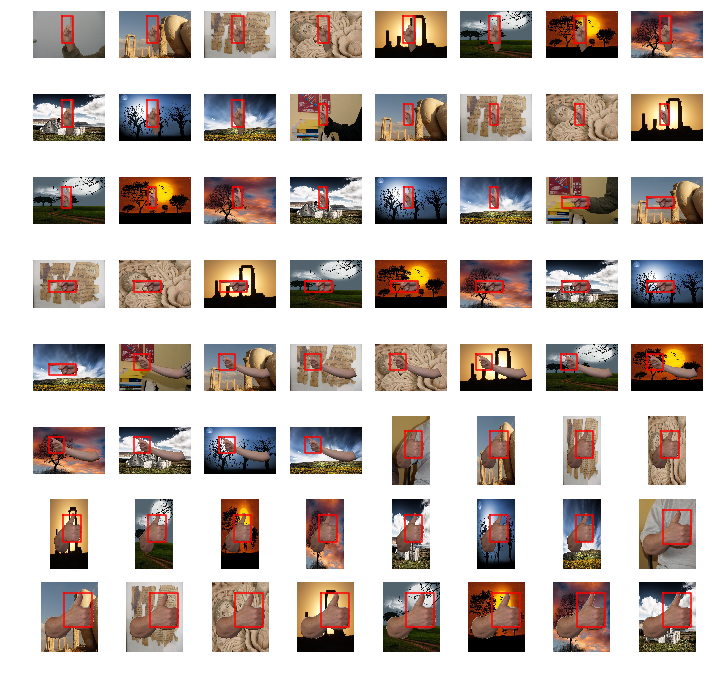

In [198]:
gs1 = gridspec.GridSpec(8, 8)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))

for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    plt.subplot(8, 8, i+1)
    
    path, x_min, y_min, x_max, y_max, class_name = lines[i].split(',')
    image = io.imread(path)
    
    plt.imshow(image)
    plt.plot([x_min, x_max, x_max, x_min, x_min],
             [y_min, y_min, y_max, y_max, y_min],
             "r-")
    
    plt.axis('off')

plt.show()

In [200]:
def write_to_file(lines):
    file = open('frcnn_data.txt', 'w')

    for line in lines:
        file.write("%s\n" % line)

### Separate images into different class folders

In [49]:
file = open('frcnn.txt', 'w')

for item in lines:
    file.write("%s\n" % item)

In [27]:
def class_separator():
    for folder in ['original_images', 'skin_masks', 'feature_points']:
    
        all_images = glob.glob('../data/' + folder + '/*')

        for img_path in all_images:
            name = img_path.split('/')[-1].split('.')[0]

            class_name = name.split('_')[0] # First character is class name
            directory = '../data/' + folder + '/' + class_name

            if not os.path.exists(directory):
                os.mkdir(directory)

            os.rename(img_path, directory + '/' + name + '.xml')


In [28]:
class_separator()

### Merge backgrounds with original images to increase sample size

In [188]:
all_backgrounds = glob.glob('../data/backgrounds/*')
print(len(all_backgrounds))
all_images = glob.glob('../data/original_images/*')
print(len(all_images))

10
10824


### Reference: http://docs.opencv.org/trunk/d0/d86/tutorial_py_image_arithmetics.html

In [187]:
import cv2

image_directory = '../data/original_images/'
skin_directory = '../data/skin_masks/'

for image_path in all_images:
    image_name = image_path.split('/')[-1].split('.')[0]
    
    image = cv2.imread(image_path)
    
    for index, background_path in enumerate(all_backgrounds):
        # Get background
        background = cv2.imread(background_path)
        background = cv2.resize(background, image.shape[:2][::-1])
        # Get skin mask
        skin = cv2.imread(skin_directory + image_name + '.bmp')
        
        skin = cv2.cvtColor(skin, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(skin, 10, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        
        # Add hand to new background
        bg = cv2.bitwise_and(background, background, mask = mask)
        fg = cv2.bitwise_and(image, image, mask = mask_inv)
        final = cv2.add(fg, bg)
        # Write to file
        new_name = image_directory + image_name + '_' + 'BG' + str(index) + '.jpg'
        cv2.imwrite(new_name, final)